## DeepLab 모델 가져오기
[DeepLab에 대한 설명](https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/)

[DeepLab 모델 데모](https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb)

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib #urllib 패키지는 웹에서 데이터를 다운로드 받을 때 사용합니다.

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


## 사진 세그멘테이션 해보기

In [4]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1350, 1080, 3)


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1350, 1080, 3) (513, 410, 3) 15


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

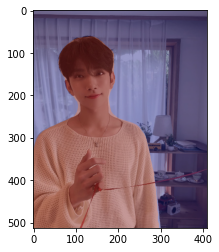

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 아웃포커싱

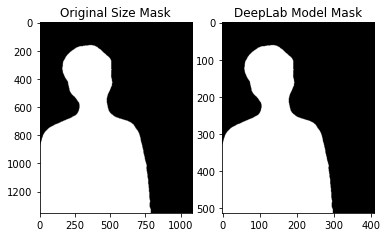

In [9]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
## inter_linear로 인해, 결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 
## 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정합니다. 128 이하면 0, 이상은 255으로 합니다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

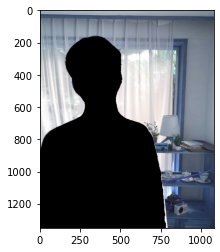

In [12]:
# 배경 추출하기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

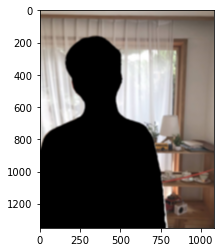

In [13]:
# 배경 흐리게 하기
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

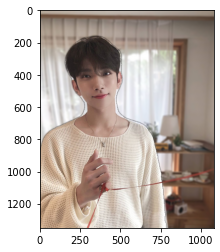

In [14]:
# 사람과 배경 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 크로마키 배경합성

In [34]:
# 합성할 배경 이미지 불러오기
import os
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
bg_orig = cv2.imread(bg_path) 
print (bg_orig.shape)

(900, 900, 3)


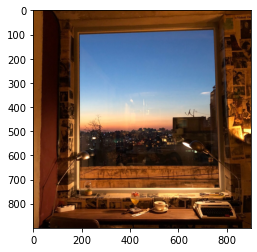

In [37]:
plt.imshow(cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB))
plt.show()

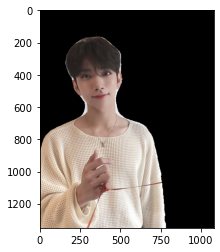

In [35]:
# 사람 사진만 불러오기
img_person = cv2.bitwise_and(img_orig, img_mask_color)
plt.imshow(cv2.cvtColor(img_person, cv2.COLOR_BGR2RGB))
plt.show()

In [38]:
print(img_person.shape)
print(bg_orig.shape)

(1350, 1080, 3)
(900, 900, 3)


In [45]:
# 두 사진 크기 똑같이 해주기
h, w = img_person.shape[:2]
min_val = min(w,h)
height, width = bg_orig.shape[:2]
max_val = max(width, height)
resize_ratio = max_val / min_val
target_size = (int(resize_ratio * w), int(resize_ratio * h))
resized_image = cv2.resize(img_person, target_size)
resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

(1125, 900, 3)


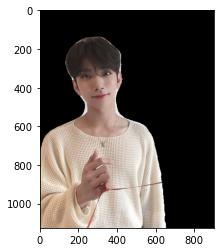

In [44]:
print(resized_image.shape)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.show()

(900, 900, 3)


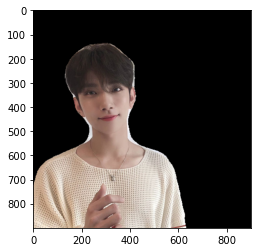

In [49]:
# crop
crop_image = resized_image[0:height, 0:width]
print(crop_image.shape)
plt.imshow(cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB))
plt.show()

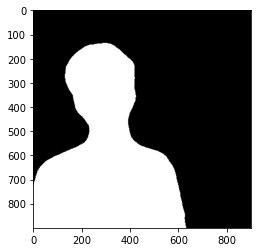

In [62]:
resized_img_mask = cv2.resize(img_mask_color, target_size)
crop_img_mask = resized_img_mask[0:height, 0:width]
plt.imshow(cv2.cvtColor(crop_img_mask, cv2.COLOR_BGR2RGB))
plt.show()

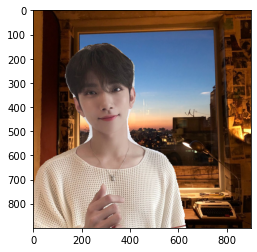

In [65]:
## 사람 부분과 배경 사진 합치기
img_concat_co = np.where(crop_img_mask==255, crop_image, bg_orig)
plt.imshow(cv2.cvtColor(img_concat_co, cv2.COLOR_BGR2RGB))
plt.show()

## 고양이 아웃포커싱

In [66]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_cat = cv2.imread(img_path) 
print (img_cat.shape)

(740, 740, 3)


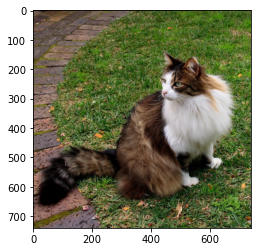

In [71]:
plt.imshow(cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB))
plt.show()

In [69]:
img_resized, seg_map = MODEL.run(img_cat)
print (img_cat.shape, img_resized.shape, seg_map.max())

(740, 740, 3) (513, 513, 3) 8


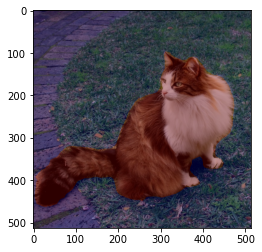

In [70]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

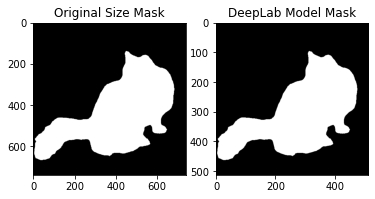

In [78]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
## inter_linear로 인해, 결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 
## 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정합니다. 128 이하면 0, 이상은 255으로 합니다.
img_mask_up_cat = cv2.resize(img_mask, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_cat = cv2.threshold(img_mask_up_cat, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_cat, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

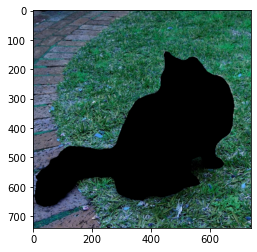

In [79]:
# 배경 추출하기
img_mask_color_cat = cv2.cvtColor(img_mask_up_cat, cv2.COLOR_GRAY2BGR)
img_bg_mask_cat = cv2.bitwise_not(img_mask_color_cat)
img_bg_cat = cv2.bitwise_and(img_cat, img_bg_mask_cat)
plt.imshow(img_bg_cat)
plt.show()

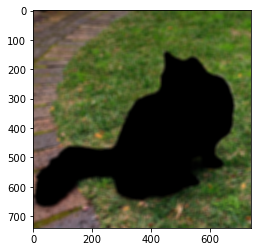

In [86]:
# 배경 흐리게 하기
img_bg_blur_cat = cv2.blur(img_bg_cat, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

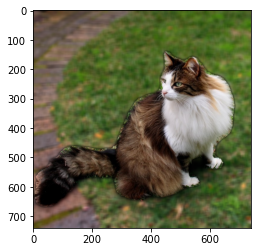

In [87]:
# 사람과 배경 합치기
img_concat_cat = np.where(img_mask_color_cat==255, img_cat, img_bg_blur_cat)
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.show()

## 발생한 문제점

![image](images/segmentation_problem.png)
1. 사람/동물의 테두리 경계선이 깨끗하게 분리되지 않는다. 따라서, 뒤에 새로운 배경에 넣거나, 블러된 배경을 넣을 때, 선명한 흰색 또는 검정색의 테두리가 남아서 지저분하게 보인다.
2. 서로 다른 이미지 두개를 합친 경우, 두 이미지의 화질 차이가 나서 아쉽다.